### Imports

In [127]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

#### Cloud

In [128]:
storage_client = storage.Client(project = 'ih-final-project-277919')
bucket = storage_client.get_bucket("data_images_ih")

#### Variables

In [129]:
#image_size
SIZE = 416
MASK_SIZE = 0.15

Download darknet and create darknet gpu

In [130]:
#!git clone https://github.com/pjreddie/darknet.git

#!wget -q https://pjreddie.com/media/files/darknet53.conv.74

# Build gpu version darknet
#!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Change 999 to fit your environment. Actually i used '-j 50'.
#!cd darknet && make -j 4 -s
#!cp darknet/darknet darknet_gpu


#### Paths

In [131]:
RAW_DATA_PATH = '/home/jupyter/raw_data/'
DATA_PATH = '/home/jupyter/data/'

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')

# YOLOv3 training weights will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup')

DATA_EXTENSION_FILE_PATH = os.path.join(CONFIG_PATH, 'ih_fp.data')

for directory in [FRAME_PATH, MASK_PATH, METADATA_PATH, CONFIG_PATH, BACKUP_PATH, RAW_DATA_PATH, DATA_PATH]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

### Data

Read classes

In [132]:
#colnames=['LabelName','Label']
#df_class = pd.read_csv(f'{RAW_DATA_PATH}/class-descriptions-boxable.csv',names=colnames, header=None)
#df_class.shape

In [133]:
#df_class.head()

Read images ids, boxes (this df can be improved)

In [134]:
annots = pd.read_csv(f'{DATA_PATH}/df_all_data.csv')
annots.shape

(79113, 9)

In [135]:
annots.head()

,ImageID,OriginalURL,ImageID.1,XMin,XMax,YMin,YMax,Label,Confidence
0,25e3acb1a25707dd,https://c6.staticflickr.com/8/7659/17891339551...,25e3acb1a25707dd,0.390625,0.999375,0.438149,0.999056,Boat,1
1,9aaa4a4bce049a85,https://farm6.staticflickr.com/8164/7388947910...,9aaa4a4bce049a85,0.015919,0.946454,0.096610,0.901695,Boat,1
2,6db5e012cf2936fa,https://c3.staticflickr.com/3/2874/9062318686_...,6db5e012cf2936fa,0.037500,0.999375,0.381341,0.999094,Boat,1
3,6db5e012cf2936fa,https://c3.staticflickr.com/3/2874/9062318686_...,6db5e012cf2936fa,0.185000,0.700000,0.241848,0.494565,Boat,1
4,6db5e012cf2936fa,https://c3.staticflickr.com/3/2874/9062318686_...,6db5e012cf2936fa,0.265625,0.778125,0.210145,0.526268,Boat,1


In [136]:
annots['Size'] = (annots['XMax'] - annots['XMin']) * (annots['YMax'] - annots['YMin'])

In [137]:
annots = annots[annots['Size'] > MASK_SIZE]

In [138]:
annots.shape

(14853, 10)

Merge both dataframes, maybe can be done on previous notebook

Dataframe only with masks

In [139]:
annots_masks = annots[['ImageID','XMin', 'XMax', 'YMin', 'YMax','Label','Confidence','Size']]
annots_masks.head()

,ImageID,XMin,XMax,YMin,YMax,Label,Confidence,Size
0,25e3acb1a25707dd,0.390625,0.999375,0.438149,0.999056,Boat,1,0.341452
1,9aaa4a4bce049a85,0.015919,0.946454,0.096610,0.901695,Boat,1,0.749160
2,6db5e012cf2936fa,0.037500,0.999375,0.381341,0.999094,Boat,1,0.594201
4,6db5e012cf2936fa,0.265625,0.778125,0.210145,0.526268,Boat,1,0.162013
5,6db5e012cf2936fa,0.333750,0.941250,0.229167,0.650362,Boat,1,0.255876


In [140]:
annots_masks.to_csv(f'{DATA_PATH}/annots_masks.csv', index = False)

Functions to save images and levels to proper folders and format

In [141]:
def save_label(MASK_PATH, image_id, row=None):

    label_fp = os.path.join(MASK_PATH, "{}.txt".format(image_id))

    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    XMin = row[1]
    XMax = row[2]
    YMin = row[3]
    YMax = row[4]
    label = row[5]
    label = 0 #as we only have one class we use 0

    rw = (XMax - XMin)
    rh = (YMax - YMin)
    rcx = XMin + rw/2
    rcy = YMin + rh/2

    line = "{} {} {} {} {}\n".format(label, rcx, rcy, rw, rh)

    f.write(line)
    f.close()

In [142]:
for row in tqdm(annots_masks.values):
        image_id = row[0]
        save_label(MASK_PATH, image_id, row)

100%|██████████| 14853/14853 [00:00<00:00, 15002.90it/s]


Dataframe with imageid and url

In [143]:
image_annots = annots[['ImageID','OriginalURL','Size']]
image_annots['OriginalURL'] = image_annots['OriginalURL'].str.replace('https://','')
image_annots.drop_duplicates(['ImageID'], inplace = True)
image_annots.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(13322, 3)

In [144]:
def save_image(FRAME_PATH, image_id, image_blob, dim):
    
    
    try:
        if os.path.isfile(os.path.join(FRAME_PATH, "{}.jpg".format(image_id)))==True:
            return
        else:
            img_fp = os.path.join(FRAME_PATH, "{}.jpg".format(image_id))
            image = np.asarray(bytearray(image_blob.download_as_string()), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
            resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

            if len(resized_image.shape) == 2:
                resized_image = cv2.cvtColor(resized_image,cv2.COLOR_GRAY2RGB)

            cv2.imwrite(img_fp, resized_image)
    except:
        #images missing that we won't add to the model

        return image_id

In [145]:
WIDTH = SIZE
HEIGHT = SIZE
dim = (WIDTH, HEIGHT)

In [146]:
not_images =[]
for row in tqdm(image_annots.values):
        image_id = row[0]
        image_blob = bucket.blob(row[1])
        not_img = save_image(FRAME_PATH, image_id,image_blob,dim)
        
        not_images.append(not_img)

100%|██████████| 13322/13322 [01:04<00:00, 205.51it/s]


In [147]:
not_images_2 = [x for x in not_images if x is not None]
image_annots = image_annots[~image_annots['ImageID'].isin(not_images_2)]

In [148]:
image_annots.to_csv(f'{DATA_PATH}/image_annots.csv', index = False)

In [149]:
#Save image_annots as csv
#Now all data is transformed

In [150]:
#Show an example

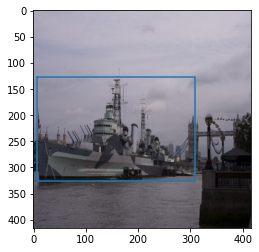

In [151]:
ex_image_id = annots.ImageID.values[200]
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
    
with open(ex_label_path, "r") as f:
    for line in f:
        x = line.strip().split()
        class_name  = x[0]
        rcx, rcy, rw, rh = [float(i) for i in x[1:]]
        x = (rcx-rw/2)*dim[0]
        y = (rcy-rh/2)*dim[1]
        w = rw*dim[0]
        h = rh*dim[1]
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])